### 
Object detection a very important problem in computer vision. Here the model is tasked with localizing the objects present in an image, and at the same time, classifying them into different categories. 

Object detection models can be broadly classified into "single-stage" and "two-stage" detectors. Two-stage detectors are often more accurate but at the cost of being slower. Here in this example, we will implement RetinaNet, a popular single-stage detector, which is accurate and runs fast. RetinaNet uses a feature pyramid network to efficiently detect objects at multiple scales and introduces a new loss, the Focal loss function, to alleviate the problem of the extreme foreground-background class imbalance.

In [4]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [5]:
os.getcwd()

'/Users/abaygi/Documents/Educational/Akhavanpour-Object-detection'

In [6]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip") #download here

In [7]:
filename

'/Users/abaygi/Documents/Educational/Akhavanpour-Object-detection/data.zip'

In [8]:
#get files and download them into my filename
keras.utils.get_file(filename, url)

'/Users/abaygi/Documents/Educational/Akhavanpour-Object-detection/data.zip'

In [9]:
#extract zipfile
with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")

In [10]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data")

2021-10-19 09:12:22.479954: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-19 09:12:22.480773: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [85]:
#dataset_info

tf.Tensor(
[[0.54380953 0.13464062 0.98651516 0.33742186]
 [0.50707793 0.517875   0.8044805  0.891125  ]
 [0.3264935  0.36971876 0.65203464 0.4431875 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[0.15716666 0.19895312 0.786375   0.38835937]
 [0.13004167 0.037      0.60314584 0.22870313]
 [0.15339583 0.803375   0.5593333  0.88628125]
 [0.11820833 0.23720312 0.25458333 0.29332814]], shape=(4, 4), dtype=float32)


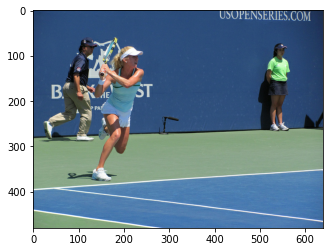

In [11]:
for sample in train_dataset.take(2): #as the take number increases (from 2 to 5), the last bbox related to the last images are shown. 
    image = sample["image"]
    bbox = sample["objects"]["bbox"]
    print(bbox)
    plt.imshow(image)

In [16]:
#utility function
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [17]:
bbox #related to take(2), i mean image 2

<tf.Tensor: id=336, shape=(4, 4), dtype=float32, numpy=
array([[0.15716666, 0.19895312, 0.786375  , 0.38835937],
       [0.13004167, 0.037     , 0.60314584, 0.22870313],
       [0.15339583, 0.803375  , 0.5593333 , 0.88628125],
       [0.11820833, 0.23720312, 0.25458333, 0.29332814]], dtype=float32)>

In [18]:
#since i have more than one bbox, i call it boxes
bbox[:, 0:1]

<tf.Tensor: id=351, shape=(4, 1), dtype=float32, numpy=
array([[0.15716666],
       [0.13004167],
       [0.15339583],
       [0.11820833]], dtype=float32)>

In [19]:
bbox[..., 0:2] #till second colomn 

<tf.Tensor: id=355, shape=(4, 2), dtype=float32, numpy=
array([[0.15716666, 0.19895312],
       [0.13004167, 0.037     ],
       [0.15339583, 0.803375  ],
       [0.11820833, 0.23720312]], dtype=float32)>

In [20]:
swaped_boxes = swap_xy(bbox)

In [21]:
swaped_boxes

<tf.Tensor: id=372, shape=(4, 4), dtype=float32, numpy=
array([[0.19895312, 0.15716666, 0.38835937, 0.786375  ],
       [0.037     , 0.13004167, 0.22870313, 0.60314584],
       [0.803375  , 0.15339583, 0.88628125, 0.5593333 ],
       [0.23720312, 0.11820833, 0.29332814, 0.25458333]], dtype=float32)>

In [22]:
def convert_to_xywh(boxes): ##center (xc, yc, w, h) the bbox are fed in this way
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [23]:
bbox[..., :2]

<tf.Tensor: id=376, shape=(4, 2), dtype=float32, numpy=
array([[0.15716666, 0.19895312],
       [0.13004167, 0.037     ],
       [0.15339583, 0.803375  ],
       [0.11820833, 0.23720312]], dtype=float32)>

In [24]:
(bbox[..., :2] + bbox[..., 2:])/2

<tf.Tensor: id=387, shape=(4, 2), dtype=float32, numpy=
array([[0.47177082, 0.29365623],
       [0.36659375, 0.13285157],
       [0.35636458, 0.8448281 ],
       [0.18639582, 0.26526564]], dtype=float32)>

In [25]:
(bbox[..., 2:] - bbox[..., :2])

<tf.Tensor: id=396, shape=(4, 2), dtype=float32, numpy=
array([[0.6292083 , 0.18940625],
       [0.47310418, 0.19170313],
       [0.4059375 , 0.08290625],
       [0.136375  , 0.05612502]], dtype=float32)>

In [26]:
convert_to_xywh(bbox)

<tf.Tensor: id=418, shape=(4, 4), dtype=float32, numpy=
array([[0.47177082, 0.29365623, 0.6292083 , 0.18940625],
       [0.36659375, 0.13285157, 0.47310418, 0.19170313],
       [0.35636458, 0.8448281 , 0.4059375 , 0.08290625],
       [0.18639582, 0.26526564, 0.136375  , 0.05612502]], dtype=float32)>

In [27]:
def convert_to_corners(boxes):#center (xc, yc, w, h)
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
        boxes[..., :2] are x, y
        boxes[..., 2:]/2.0 are w, h

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [28]:
corners = convert_to_corners(bbox)

In [29]:
corners_np = corners.numpy()

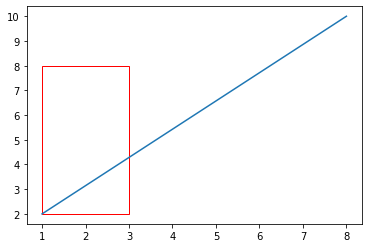

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([1, 8],[2, 10]) #x1=1, x2=8 [1, 8]

#add rectangle to plot
ax.add_patch(Rectangle((1, 2),
                       2,
                       6,
                      fill=False, 
                      color='red'))

#display plot
plt.show()


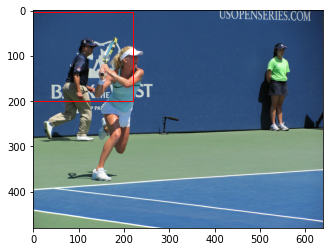

In [31]:
#https://www.statology.org/matplotlib-rectangle/
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.imshow(image)

#add rectangle to plot
ax.add_patch(Rectangle((corners_np[0][0]*700, 
                        corners_np[0][1]*500), 
                       corners_np[0][2]*700, 
                       corners_np[0][3]*500,
                       fill=False,
                       color="red"))
plt.show()

In [32]:
#in order to plot a bbox, you need to convert it into corners. It is worth nothing that coco's  bbox are in this format
# [x, y, width, height]
corners = convert_to_corners(bbox)

In [33]:
corners_np = corners.numpy()

In [34]:
corners_np

array([[-0.23602083,  0.00477344,  0.5503541 ,  0.3931328 ],
       [-0.17153125, -0.07735156,  0.43161458,  0.15135157],
       [-0.12627083,  0.36023438,  0.4330625 ,  1.2465156 ],
       [-0.00908333,  0.09053905,  0.2455    ,  0.3838672 ]],
      dtype=float32)

In [35]:
#intersection overunion
#boxe0_np[:, :2] # till second columns 
#boxe0_np[..., :2]

In [36]:
boxes1_corners = corners[2:3, :]
boxes2_corners = corners[3:4, :]

In [37]:
boxes2_corners

<tf.Tensor: id=474, shape=(1, 4), dtype=float32, numpy=
array([[-0.00908333,  0.09053905,  0.2455    ,  0.3838672 ]],
      dtype=float32)>

In [38]:
corners

<tf.Tensor: id=466, shape=(4, 4), dtype=float32, numpy=
array([[-0.23602083,  0.00477344,  0.5503541 ,  0.3931328 ],
       [-0.17153125, -0.07735156,  0.43161458,  0.15135157],
       [-0.12627083,  0.36023438,  0.4330625 ,  1.2465156 ],
       [-0.00908333,  0.09053905,  0.2455    ,  0.3838672 ]],
      dtype=float32)>

In [39]:
#boxes1_corners[:, None, :2] #numpy=array([[[-0.23602083,  0.00477344]]]
boxes2_corners[:, :2]

<tf.Tensor: id=478, shape=(1, 2), dtype=float32, numpy=array([[-0.00908333,  0.09053905]], dtype=float32)>

In [40]:
lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2]) #maximum (xcmin1, xcmin2) and max(ycmin1, ycmin2)
rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:]) #min (xcmax1, xcmax2) and min(ycmax1, ycmax2) 

In [41]:
lu

<tf.Tensor: id=487, shape=(1, 1, 2), dtype=float32, numpy=array([[[-0.00908333,  0.36023438]]], dtype=float32)>

In [42]:
#lu #numpy=array([[[-0.17153125,  0.00477344]]]
rd

<tf.Tensor: id=496, shape=(1, 1, 2), dtype=float32, numpy=array([[[0.2455   , 0.3838672]]], dtype=float32)>

In [45]:

bbox[0]

<tf.Tensor: id=556, shape=(4,), dtype=float32, numpy=array([0.15716666, 0.19895312, 0.786375  , 0.38835937], dtype=float32)>

### I need corners here!
x1, y1, x2, y2 = box

w, h = x2 - x1, y2 - y1

patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth

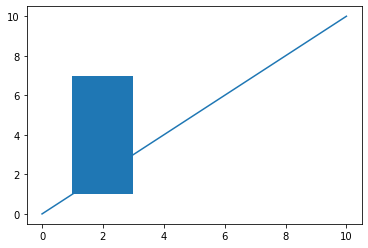

In [52]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((1, 1), 2, 6))

#display plot
plt.show()

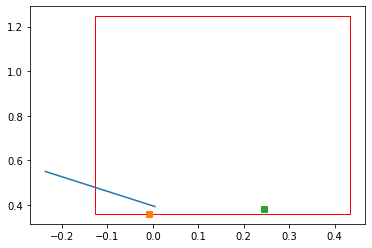

In [55]:
#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([corners_np[0][0], corners_np[0][1]],[corners_np[0][2], corners_np[0][3]])
ax.plot(-0.0090833, 0.36, "s")
ax.plot(0.2455, 0.3838, "s")
#add rectangle to plot (not corners but xc, yc, and w, c)
ax.add_patch(Rectangle((corners_np[2][0], 
                        corners_np[2][1]), 
                        (corners_np[2][2]-corners_np[2][0]), 
                        (corners_np[2][3]-corners_np[2][1]),
                        fill=False,
                       color="red"))

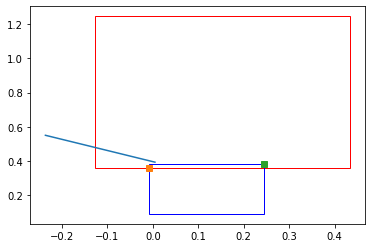

In [56]:
#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([corners_np[0][0], corners_np[0][1]],[corners_np[0][2], corners_np[0][3]])
ax.plot(-0.0090833, 0.36, "s")
ax.plot(0.2455, 0.3838, "s")
#add rectangle to plot (not corners but xc, yc, and w, c)
ax.add_patch(Rectangle((corners_np[2][0], 
                        corners_np[2][1]), 
                        (corners_np[2][2]-corners_np[2][0]), 
                        (corners_np[2][3]-corners_np[2][1]),
                        fill=False,
                       color="red"))
ax.add_patch(Rectangle((corners_np[3][0], 
                        corners_np[3][1]), 
                        (corners_np[3][2]-corners_np[3][0]) , 
                        (corners_np[3][3]-corners_np[3][1]),
                        fill=False,
                        color="blue"))

#display plot
#plt.show()

In [57]:
boxes1 = bbox[0:1, :]
boxes2 = bbox[1:2, :]

In [58]:
#Computing pairwise Intersection Over Union (IOU) (why do i need corners[x, y, width, height])
def compute_iou(boxes1, boxes2): #box2 is my ground truth (the difference between prediction and gound truth)
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2]) #left up 
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:]) #right down 
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3] #width1 and height1
    boxes2_area = boxes2[:, 2] * boxes2[:, 3] #width2 and height2
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [59]:
compute_iou(boxes1, boxes2)

<tf.Tensor: id=933, shape=(1, 1), dtype=float32, numpy=array([[0.24908611]], dtype=float32)>

In [60]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


### 
1) Building the ResNet50 backbone

2) Building Feature Pyramid Network as a custom layer

3) Building the classification and box regression heads.

In [120]:
backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3])

In [121]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [122]:
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

In [123]:
fp = FeaturePyramid()

In [128]:
fp.backbone.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Building Feature Pyramid Network as a custom layer

In [129]:
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [130]:
fp = FeaturePyramid()

In [132]:
fp.call()

TypeError: call() missing 1 required positional argument: 'images'